# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

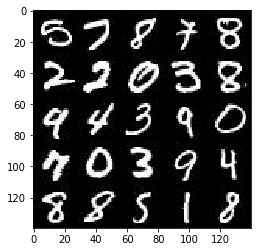

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

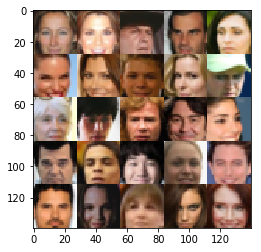

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z") 
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return inputs_real, inputs_z, learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    alpha = 0.2
        
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Start conv stack
        
        # Input layer shape 28x28x3 
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1) # relu1.shape: 14x14x64
                
                
        # Second convolution layer
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2) # relu2.shape: 7x7x128
                
        # Third convolution layer
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)  # relu3.shape: 4x4x256
              
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
                              
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
from IPython.core.debugger import set_trace

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
             
    with tf.variable_scope('generator', reuse=not is_train):
        
        # reuse = not is_train should be used because we want to reuse the parameters when we are generating 
        # the samples but that will not be during the training. 
        # initially the generator will start off by training and not by generating images....
        # so the value of is_train should be True...because it decides whether generator is training or not
        
        # https://stackoverflow.com/questions/35980044/getting-the-output-shape-of-deconvolution-layer-using-tf-nn-conv2d-transpose-in
               
        # First fully connected layer
        # x1 = tf.layers.dense(z, 2*2*256) # starting with this number of units performs worse
        x1 = tf.layers.dense(z, 7*7*256)
                
        # Reshape and start deconv stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1) # shape: 7x7x256
   
        # Second convolution layer
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')   
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2) # shape 14x14x128
        
        # Third convolution layer    
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3) # shape: 28x28x64
        # print(x3.shape)
        
        # Dropout --> loss is not improving adding dropout
        drop = tf.nn.dropout(x3, keep_prob=0.5)
               
        # Output layer
        logits = tf.layers.conv2d_transpose(drop, out_channel_dim, 5, strides=1, padding='same')
               
        # print(logits.shape) # 28x28x5
                               
        out = tf.tanh(logits)
            
        return out
       


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    smooth = 0.1 # label smoothing
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
        
    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # https://discussions.udacity.com/t/project-5-net-not-training/246936/10
    
    # Get weights and bias to update
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    print_every=10 
    show_every=100
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                # https://discussions.udacity.com/t/generator-loss-greater-than-discriminator-loss/247897/3
                
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5107... Generator Loss: 5.1554
Epoch 1/2... Discriminator Loss: 0.9794... Generator Loss: 1.0636
Epoch 1/2... Discriminator Loss: 1.5484... Generator Loss: 3.6063
Epoch 1/2... Discriminator Loss: 1.7872... Generator Loss: 1.7841
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 1.7719
Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 1.0445
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 1.2247
Epoch 1/2... Discriminator Loss: 1.2570... Generator Loss: 1.1373
Epoch 1/2... Discriminator Loss: 1.2485... Generator Loss: 1.0109
Epoch 1/2... Discriminator Loss: 1.4212... Generator Loss: 1.6451


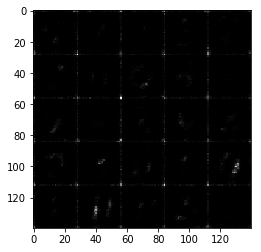

Epoch 1/2... Discriminator Loss: 1.5919... Generator Loss: 1.8841
Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 1.1002
Epoch 1/2... Discriminator Loss: 1.4242... Generator Loss: 1.1904
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 1.8207
Epoch 1/2... Discriminator Loss: 1.5600... Generator Loss: 2.1939
Epoch 1/2... Discriminator Loss: 2.2096... Generator Loss: 2.7265
Epoch 1/2... Discriminator Loss: 1.1992... Generator Loss: 1.2663
Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 1.0099
Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 0.8137
Epoch 1/2... Discriminator Loss: 1.2173... Generator Loss: 1.1355


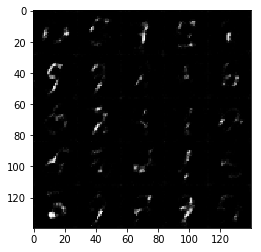

Epoch 1/2... Discriminator Loss: 1.3159... Generator Loss: 0.7822
Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 0.8625
Epoch 1/2... Discriminator Loss: 1.8259... Generator Loss: 0.3001
Epoch 1/2... Discriminator Loss: 1.8321... Generator Loss: 2.3423
Epoch 1/2... Discriminator Loss: 1.5193... Generator Loss: 1.4352
Epoch 1/2... Discriminator Loss: 1.6419... Generator Loss: 1.1840
Epoch 1/2... Discriminator Loss: 1.2150... Generator Loss: 0.8323
Epoch 1/2... Discriminator Loss: 1.5525... Generator Loss: 0.4326
Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 0.6413
Epoch 1/2... Discriminator Loss: 1.4384... Generator Loss: 0.5765


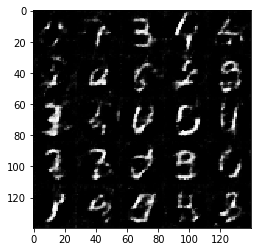

Epoch 1/2... Discriminator Loss: 1.5258... Generator Loss: 0.4448
Epoch 1/2... Discriminator Loss: 1.3373... Generator Loss: 1.1041
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 1.3908
Epoch 1/2... Discriminator Loss: 1.4308... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 1.2898
Epoch 1/2... Discriminator Loss: 1.5722... Generator Loss: 1.5459
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 0.8555
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 0.5252
Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 0.5881
Epoch 1/2... Discriminator Loss: 1.2765... Generator Loss: 0.5549


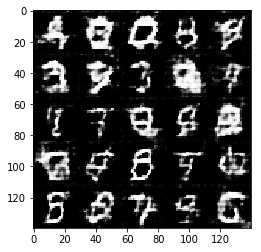

Epoch 1/2... Discriminator Loss: 1.4708... Generator Loss: 0.5263
Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 1.4935
Epoch 1/2... Discriminator Loss: 1.2810... Generator Loss: 1.1006
Epoch 1/2... Discriminator Loss: 1.2487... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 1.0212
Epoch 1/2... Discriminator Loss: 1.5075... Generator Loss: 0.4668
Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 1.3692
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 0.9313
Epoch 1/2... Discriminator Loss: 1.4157... Generator Loss: 1.5390
Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 0.6934


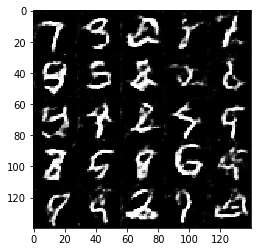

Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.7266
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 1.0601
Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.5228
Epoch 1/2... Discriminator Loss: 1.4643... Generator Loss: 0.4829
Epoch 1/2... Discriminator Loss: 1.2934... Generator Loss: 0.6824
Epoch 1/2... Discriminator Loss: 1.6305... Generator Loss: 0.4231
Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 1.4101
Epoch 1/2... Discriminator Loss: 1.5504... Generator Loss: 1.8574
Epoch 1/2... Discriminator Loss: 1.2480... Generator Loss: 0.8154
Epoch 1/2... Discriminator Loss: 1.7327... Generator Loss: 0.3490


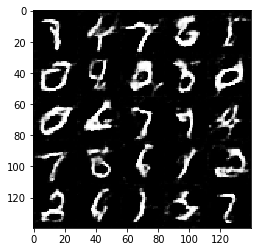

Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.9078
Epoch 1/2... Discriminator Loss: 1.7496... Generator Loss: 0.3503
Epoch 1/2... Discriminator Loss: 1.2035... Generator Loss: 0.7402
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.5230
Epoch 1/2... Discriminator Loss: 1.4172... Generator Loss: 0.9874
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.6318
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 1.0188
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.6529
Epoch 1/2... Discriminator Loss: 1.6260... Generator Loss: 0.4195
Epoch 1/2... Discriminator Loss: 1.2933... Generator Loss: 0.5760


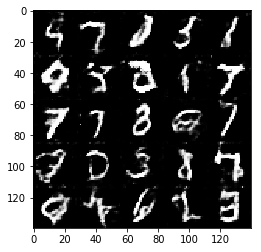

Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 0.4584
Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 1.2160
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 1.2127
Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 1.1776
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 0.8828
Epoch 1/2... Discriminator Loss: 1.4718... Generator Loss: 0.5762
Epoch 1/2... Discriminator Loss: 1.3284... Generator Loss: 0.5937
Epoch 1/2... Discriminator Loss: 1.3031... Generator Loss: 0.5935
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 1.2639
Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 0.6527


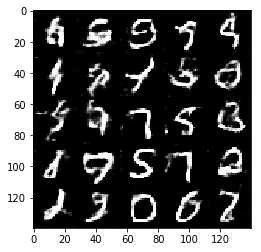

Epoch 1/2... Discriminator Loss: 1.5207... Generator Loss: 0.4847
Epoch 1/2... Discriminator Loss: 1.5410... Generator Loss: 0.5550
Epoch 1/2... Discriminator Loss: 1.4354... Generator Loss: 0.4838
Epoch 1/2... Discriminator Loss: 1.4884... Generator Loss: 0.5041
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 1.3239
Epoch 1/2... Discriminator Loss: 1.5689... Generator Loss: 1.7494
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 1.0282
Epoch 1/2... Discriminator Loss: 1.1868... Generator Loss: 1.5610
Epoch 1/2... Discriminator Loss: 1.4681... Generator Loss: 1.3249
Epoch 1/2... Discriminator Loss: 1.2403... Generator Loss: 0.6616


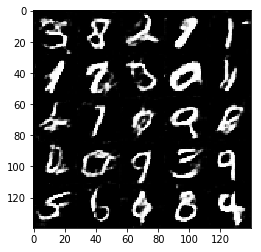

Epoch 1/2... Discriminator Loss: 1.1397... Generator Loss: 0.7795
Epoch 1/2... Discriminator Loss: 1.1102... Generator Loss: 1.5429
Epoch 1/2... Discriminator Loss: 1.6455... Generator Loss: 2.5547
Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 0.7849
Epoch 2/2... Discriminator Loss: 1.2785... Generator Loss: 0.8074
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 0.8711
Epoch 2/2... Discriminator Loss: 1.3319... Generator Loss: 1.8073
Epoch 2/2... Discriminator Loss: 1.1535... Generator Loss: 1.0446
Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 1.5514
Epoch 2/2... Discriminator Loss: 1.1102... Generator Loss: 1.0781


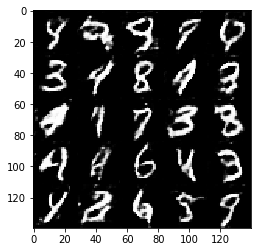

Epoch 2/2... Discriminator Loss: 1.8356... Generator Loss: 0.3103
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 0.9641
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 0.5205
Epoch 2/2... Discriminator Loss: 1.1097... Generator Loss: 1.4809
Epoch 2/2... Discriminator Loss: 1.1789... Generator Loss: 1.6897
Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 0.6044
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 1.2628
Epoch 2/2... Discriminator Loss: 1.9919... Generator Loss: 0.2759
Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 1.1945
Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 0.6556


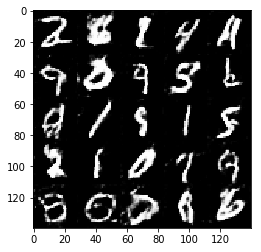

Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 1.7209
Epoch 2/2... Discriminator Loss: 0.9712... Generator Loss: 2.0671
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 1.3840
Epoch 2/2... Discriminator Loss: 1.2300... Generator Loss: 1.6987
Epoch 2/2... Discriminator Loss: 2.0404... Generator Loss: 0.2808
Epoch 2/2... Discriminator Loss: 1.0375... Generator Loss: 1.4992
Epoch 2/2... Discriminator Loss: 1.0980... Generator Loss: 1.0635
Epoch 2/2... Discriminator Loss: 1.4673... Generator Loss: 0.4464
Epoch 2/2... Discriminator Loss: 0.9069... Generator Loss: 1.4200
Epoch 2/2... Discriminator Loss: 1.3642... Generator Loss: 0.5717


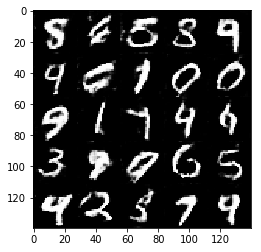

Epoch 2/2... Discriminator Loss: 1.6926... Generator Loss: 0.3995
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 1.1990
Epoch 2/2... Discriminator Loss: 1.0581... Generator Loss: 1.4369
Epoch 2/2... Discriminator Loss: 0.9492... Generator Loss: 1.3981
Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 1.4677
Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 0.6350
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 1.3751
Epoch 2/2... Discriminator Loss: 0.9105... Generator Loss: 1.0084
Epoch 2/2... Discriminator Loss: 1.0650... Generator Loss: 2.0467
Epoch 2/2... Discriminator Loss: 1.4295... Generator Loss: 0.5349


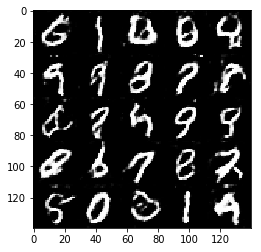

Epoch 2/2... Discriminator Loss: 1.4059... Generator Loss: 0.5297
Epoch 2/2... Discriminator Loss: 1.2203... Generator Loss: 1.4741
Epoch 2/2... Discriminator Loss: 0.9732... Generator Loss: 1.0683
Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 0.9915
Epoch 2/2... Discriminator Loss: 1.1772... Generator Loss: 0.7484
Epoch 2/2... Discriminator Loss: 1.2653... Generator Loss: 1.8745
Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 0.6828
Epoch 2/2... Discriminator Loss: 0.9178... Generator Loss: 1.2462
Epoch 2/2... Discriminator Loss: 1.0255... Generator Loss: 1.1653
Epoch 2/2... Discriminator Loss: 1.6246... Generator Loss: 0.4162


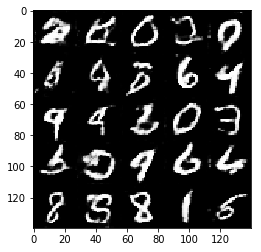

Epoch 2/2... Discriminator Loss: 1.8290... Generator Loss: 0.3426
Epoch 2/2... Discriminator Loss: 1.0714... Generator Loss: 0.9602
Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 1.3143
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 0.5375
Epoch 2/2... Discriminator Loss: 1.5257... Generator Loss: 0.5511
Epoch 2/2... Discriminator Loss: 0.8098... Generator Loss: 1.2803
Epoch 2/2... Discriminator Loss: 1.0329... Generator Loss: 2.2430
Epoch 2/2... Discriminator Loss: 0.9615... Generator Loss: 0.9190
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 2.8339
Epoch 2/2... Discriminator Loss: 0.9771... Generator Loss: 1.0339


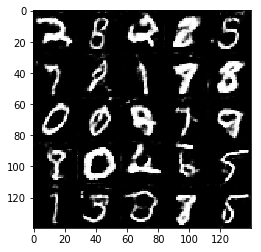

Epoch 2/2... Discriminator Loss: 1.0981... Generator Loss: 0.7829
Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 2.3788
Epoch 2/2... Discriminator Loss: 0.9291... Generator Loss: 1.5352
Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 1.0282
Epoch 2/2... Discriminator Loss: 1.0564... Generator Loss: 0.7917
Epoch 2/2... Discriminator Loss: 0.7465... Generator Loss: 2.2029
Epoch 2/2... Discriminator Loss: 1.1674... Generator Loss: 0.8914
Epoch 2/2... Discriminator Loss: 1.6335... Generator Loss: 0.4194
Epoch 2/2... Discriminator Loss: 0.7281... Generator Loss: 1.6182
Epoch 2/2... Discriminator Loss: 1.2225... Generator Loss: 0.6857


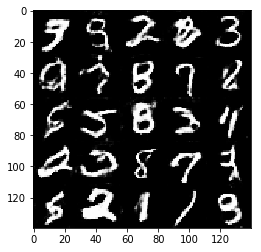

Epoch 2/2... Discriminator Loss: 0.7799... Generator Loss: 2.2696
Epoch 2/2... Discriminator Loss: 1.1390... Generator Loss: 0.7762
Epoch 2/2... Discriminator Loss: 1.0212... Generator Loss: 1.4036
Epoch 2/2... Discriminator Loss: 0.7825... Generator Loss: 1.6172
Epoch 2/2... Discriminator Loss: 0.9892... Generator Loss: 1.2960
Epoch 2/2... Discriminator Loss: 1.2619... Generator Loss: 0.6747
Epoch 2/2... Discriminator Loss: 1.5223... Generator Loss: 0.5293
Epoch 2/2... Discriminator Loss: 0.8285... Generator Loss: 1.9862
Epoch 2/2... Discriminator Loss: 0.9013... Generator Loss: 1.8768
Epoch 2/2... Discriminator Loss: 0.6439... Generator Loss: 1.7006


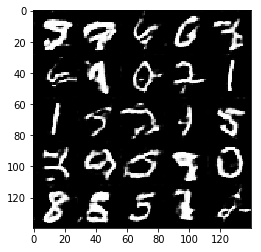

Epoch 2/2... Discriminator Loss: 0.8179... Generator Loss: 1.3442
Epoch 2/2... Discriminator Loss: 2.6988... Generator Loss: 4.0887
Epoch 2/2... Discriminator Loss: 1.4782... Generator Loss: 0.5254
Epoch 2/2... Discriminator Loss: 0.7353... Generator Loss: 2.3005
Epoch 2/2... Discriminator Loss: 1.0182... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 2.6044
Epoch 2/2... Discriminator Loss: 1.1488... Generator Loss: 0.7659
Epoch 2/2... Discriminator Loss: 1.3263... Generator Loss: 0.6495
Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 0.7444
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.6651


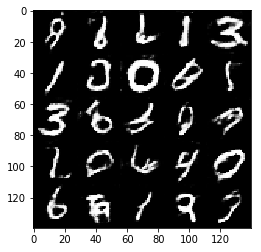

Epoch 2/2... Discriminator Loss: 0.8556... Generator Loss: 1.2018
Epoch 2/2... Discriminator Loss: 1.5362... Generator Loss: 0.5903
Epoch 2/2... Discriminator Loss: 1.0920... Generator Loss: 1.5152
Epoch 2/2... Discriminator Loss: 1.2084... Generator Loss: 0.6717
Epoch 2/2... Discriminator Loss: 0.8828... Generator Loss: 1.2268
Epoch 2/2... Discriminator Loss: 1.4173... Generator Loss: 0.6479
Epoch 2/2... Discriminator Loss: 1.4550... Generator Loss: 0.5301


In [25]:
batch_size = 64 # worse with 32 and greater lr
z_dim = 100
learning_rate = 0.002 # worse with greater lr
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7669... Generator Loss: 5.6251
Epoch 1/1... Discriminator Loss: 1.9704... Generator Loss: 4.1304
Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 2.7174
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.0987
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.2389
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 1.9390
Epoch 1/1... Discriminator Loss: 2.4806... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.4918
Epoch 1/1... Discriminator Loss: 3.4791... Generator Loss: 0.0940


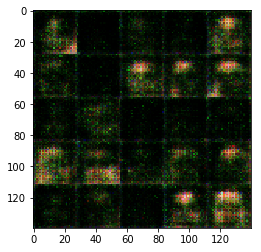

Epoch 1/1... Discriminator Loss: 1.6562... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.9906... Generator Loss: 0.3442
Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.4202
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.4154
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.4628
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.5890
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 2.0526... Generator Loss: 0.3101


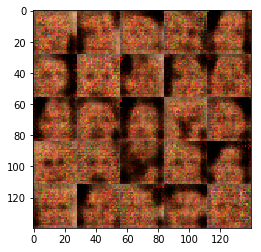

Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.7412... Generator Loss: 1.8025
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 1.3360
Epoch 1/1... Discriminator Loss: 1.5708... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 1.0572
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.8192


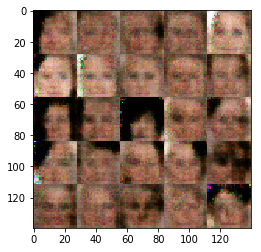

Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 2.7560... Generator Loss: 2.9699
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 2.6467... Generator Loss: 0.1436
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 1.0507
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.9026


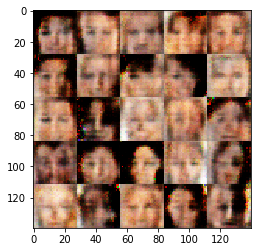

Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 1.5754
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.6525... Generator Loss: 0.4021
Epoch 1/1... Discriminator Loss: 1.6609... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 1.8579... Generator Loss: 0.2973
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 1.0288


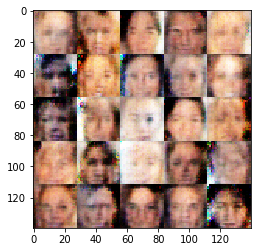

Epoch 1/1... Discriminator Loss: 1.6984... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.7676... Generator Loss: 1.7776
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.9905


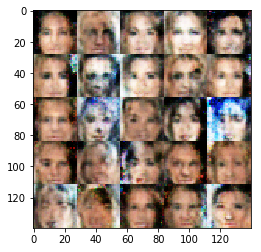

Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6464


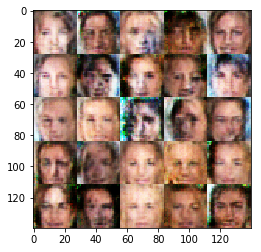

Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.6504... Generator Loss: 1.3504
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6736


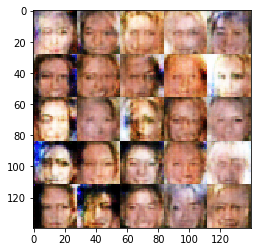

Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 1.0259


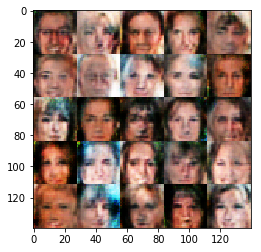

Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.8230


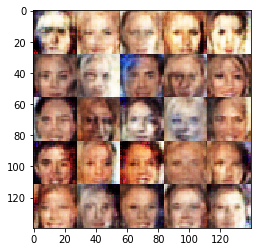

Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.5713


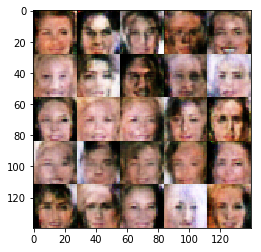

Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.9560


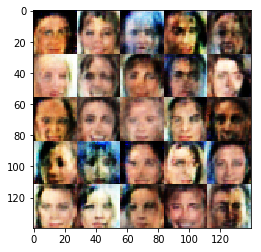

Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7311


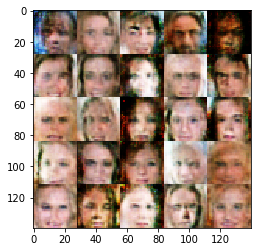

Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.8644


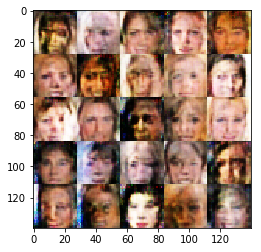

Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.5167
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8178


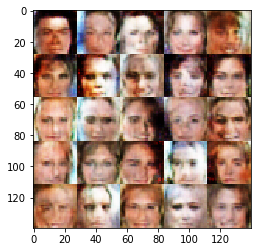

Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6795


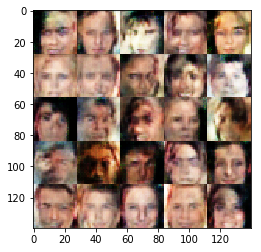

Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.6496


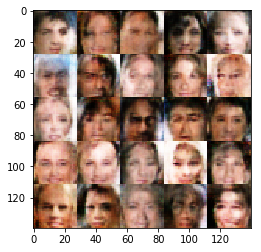

Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.8556


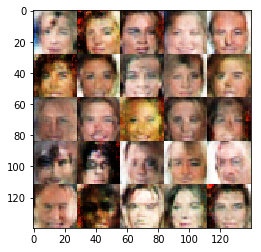

Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 1.1313
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.8517


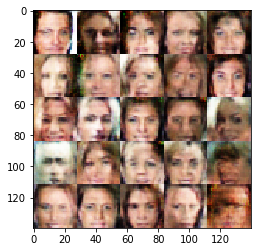

Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.6941


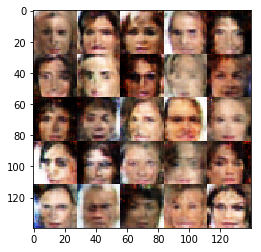

Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 1.1764
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.9346


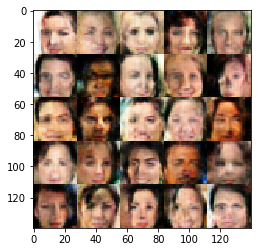

Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6706


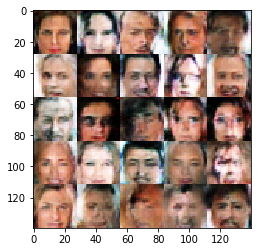

Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6395


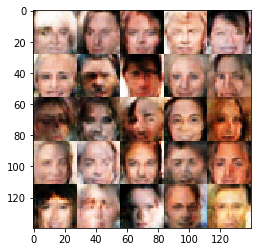

Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.8176


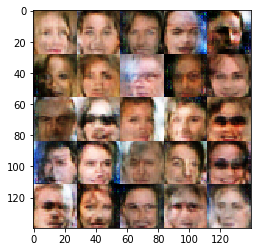

Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6334


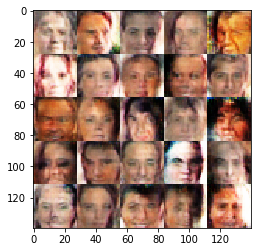

Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7854


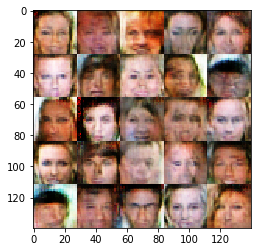

Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.7801


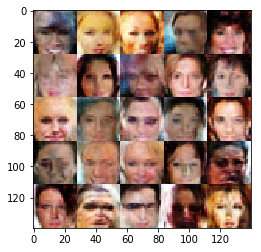

Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.9014


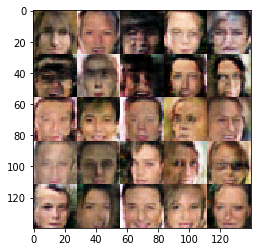

Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.5512


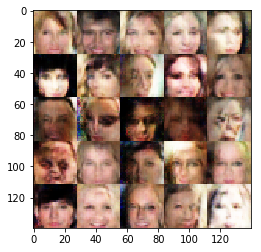

Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6772


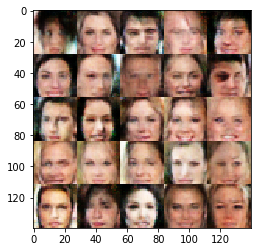

Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.7800


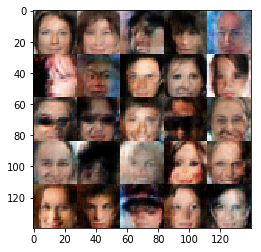

Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8167


In [26]:
batch_size = 64 # worse with 32 and greater lr
z_dim = 100
learning_rate = 0.002 # worse with greater lr
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.